# Packages 

In [1]:
#install pyathena if needed
#!pip install pyathena
from pyathena import connect

In [2]:
import boto3
import sagemaker

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import seaborn as sns
from pathlib import Path

import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set_style = "seaborn-whitegrid"

sns.set(
    rc={
        "font.style": "normal",
        "axes.facecolor": "white",
        "grid.color": ".8",
        "grid.linestyle": "-",
        "figure.facecolor": "white",
        "figure.titlesize": 20,
        "text.color": "black",
        "xtick.color": "black",
        "ytick.color": "black",
        "axes.labelcolor": "black",
        "axes.grid": True,
        "axes.labelsize": 10,
        "xtick.labelsize": 10,
        "font.size": 10,
        "ytick.labelsize": 10,
    }
)

# Set-up

In [3]:
sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

# Read Merged Data from Public S3 Bucket

In [4]:
# Public Flight Data
s3_client = boto3.client("s3")

BUCKET='ads-508-airline'
KEY='merged/Dec_modeling.csv'

response = s3_client.get_object(Bucket=BUCKET, Key=KEY)

pd.set_option('display.expand_frame_repr', False)
dec_merged = pd.read_csv(response.get("Body"))
dec_merged.head()

,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,TAIL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,DEST,DEP_DEL15,DEP_TIME_BLK,ARR_TIME_BLK,CANCELLED,CRS_ELAPSED_TIME,DISTANCE,DISTANCE_GROUP,AIRLINE_ID,CARRIER_NAME,PILOTS_COPILOTS,PASSENGER_HANDLING,PASS_GEN_SVC_ADMIN,MAINTENANCE,PRCP,SNOW,SNWD,TMAX,AWND
0,8,7,WN,N8651A,15016,STL,SAN,0.0,1100-1159,1300-1359,0.0,245.0,1557.0,7,19393,Southwest Airlines Co.,8989,9668,15475,2482,0.02,0.0,0.0,58.0,9.84
1,8,7,WN,N939WN,15016,STL,SAT,0.0,1200-1259,1400-1459,0.0,145.0,786.0,4,19393,Southwest Airlines Co.,8989,9668,15475,2482,0.02,0.0,0.0,58.0,9.84
2,8,7,WN,N7741C,15016,STL,SAT,0.0,2100-2159,0001-0559,0.0,140.0,786.0,4,19393,Southwest Airlines Co.,8989,9668,15475,2482,0.02,0.0,0.0,58.0,9.84
3,8,7,WN,N550WN,15016,STL,SEA,0.0,0900-0959,1200-1259,0.0,275.0,1709.0,7,19393,Southwest Airlines Co.,8989,9668,15475,2482,0.02,0.0,0.0,58.0,9.84
4,8,7,WN,N8319F,15016,STL,SFO,1.0,1800-1859,2000-2059,0.0,270.0,1735.0,7,19393,Southwest Airlines Co.,8989,9668,15475,2482,0.02,0.0,0.0,58.0,9.84


In [5]:
dec_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 558026 entries, 0 to 558025
Data columns (total 25 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   DAY_OF_MONTH        558026 non-null  int64  
 1   DAY_OF_WEEK         558026 non-null  int64  
 2   OP_UNIQUE_CARRIER   558026 non-null  object 
 3   TAIL_NUM            558026 non-null  object 
 4   ORIGIN_AIRPORT_ID   558026 non-null  int64  
 5   ORIGIN              558026 non-null  object 
 6   DEST                558026 non-null  object 
 7   DEP_DEL15           558026 non-null  float64
 8   DEP_TIME_BLK        558026 non-null  object 
 9   ARR_TIME_BLK        558026 non-null  object 
 10  CANCELLED           558026 non-null  float64
 11  CRS_ELAPSED_TIME    558026 non-null  float64
 12  DISTANCE            558026 non-null  float64
 13  DISTANCE_GROUP      558026 non-null  int64  
 14  AIRLINE_ID          558026 non-null  int64  
 15  CARRIER_NAME        558026 non-nul

# Explore Class Labels 

In [6]:
dec_merged.shape

(558026, 25)

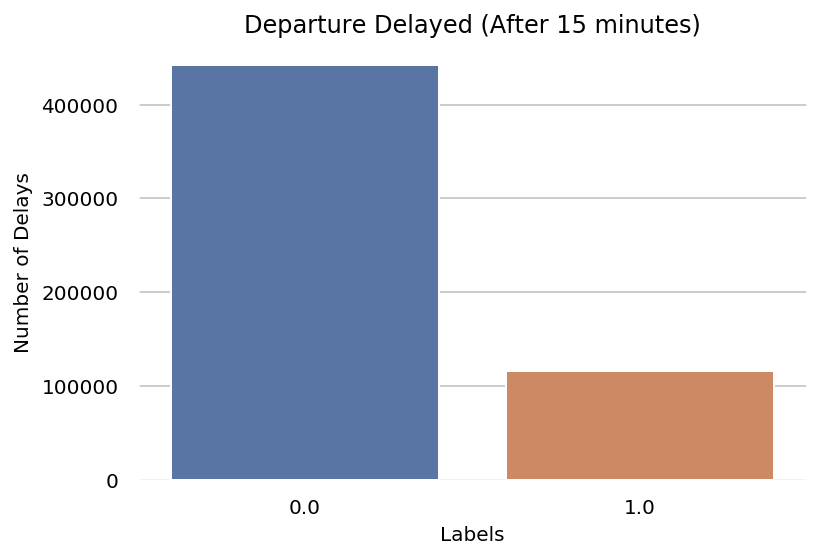

In [7]:
fig = sns.countplot(data=dec_merged, x="DEP_DEL15")
fig.set_xlabel("Labels")
fig.set_ylabel("Number of Delays")
fig.set_title("Departure Delayed (After 15 minutes)")
plt.show()

# Balance the Dataset by Departures 

In [8]:
df_grouped_by = dec_merged.groupby(["DEP_DEL15"])
df_balanced = df_grouped_by.apply(lambda x: x.sample(df_grouped_by.size().min()))
df_balanced.reset_index(drop=True, inplace =True)
df_balanced.head()

,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,TAIL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,DEST,DEP_DEL15,DEP_TIME_BLK,ARR_TIME_BLK,CANCELLED,CRS_ELAPSED_TIME,DISTANCE,DISTANCE_GROUP,AIRLINE_ID,CARRIER_NAME,PILOTS_COPILOTS,PASSENGER_HANDLING,PASS_GEN_SVC_ADMIN,MAINTENANCE,PRCP,SNOW,SNWD,TMAX,AWND
0,6,5,WN,N924WN,12191,HOU,DAL,0.0,0600-0659,0700-0759,0.0,60.0,239.0,1,19393,Southwest Airlines Co.,8989,9668,15475,2482,0.00,0.0,0.0,75.0,9.62
1,26,4,OH,N524AE,11057,CLT,AVL,0.0,0900-0959,1000-1059,0.0,56.0,91.0,1,20417,Comair Inc.,1729,0,1345,471,0.00,0.0,0.0,63.0,1.12
2,21,6,OH,N556NN,13931,ORF,PHL,0.0,1700-1759,1800-1859,0.0,68.0,212.0,1,20417,Comair Inc.,1729,0,1345,471,0.00,0.0,0.0,46.0,5.14
3,8,7,NK,N523NK,14492,RDU,MCO,0.0,1100-1159,1300-1359,0.0,116.0,534.0,3,20416,Spirit Air Lines,2126,264,3592,395,0.11,0.0,0.0,52.0,3.58
4,8,7,DL,N542US,14747,SEA,MSP,0.0,0800-0859,1300-1359,0.0,200.0,1399.0,6,19790,Delta Air Lines Inc.,9293,15331,15809,6122,0.03,0.0,0.0,52.0,3.80


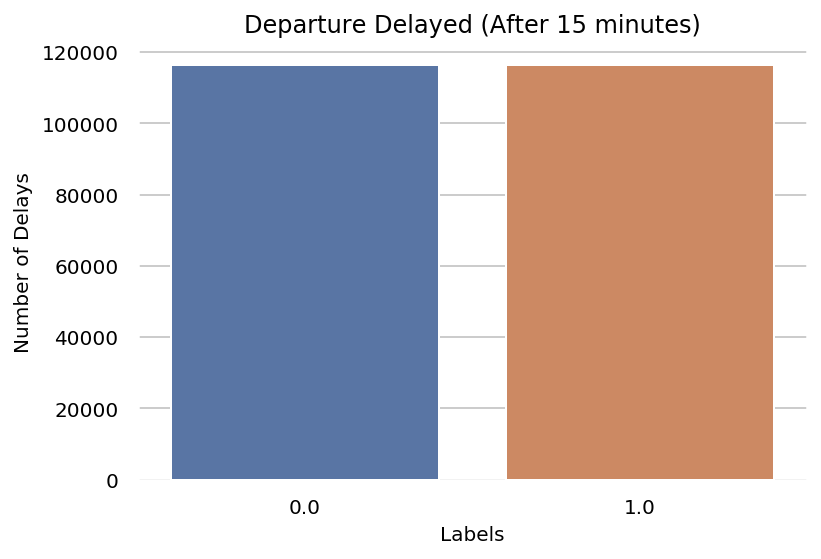

In [9]:
fig = sns.countplot(data=df_balanced, x="DEP_DEL15")
fig.set_xlabel("Labels")
fig.set_ylabel("Number of Delays")
fig.set_title("Departure Delayed (After 15 minutes)")
plt.show()

# Feature Engineering 

1. Feature Selection
2. Feature Creation 
3. Feature Transformation

----

## 1. Feature Selection 

- We will disregard columns with IDs
- Also drop any redundant columns such as having only 1 distinct value 
- Since we have both the distance and distance group column, it is redundant or DEP_TIME_BLK vs. ARR_TIME_BLK

In [10]:
df_balanced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232584 entries, 0 to 232583
Data columns (total 25 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   DAY_OF_MONTH        232584 non-null  int64  
 1   DAY_OF_WEEK         232584 non-null  int64  
 2   OP_UNIQUE_CARRIER   232584 non-null  object 
 3   TAIL_NUM            232584 non-null  object 
 4   ORIGIN_AIRPORT_ID   232584 non-null  int64  
 5   ORIGIN              232584 non-null  object 
 6   DEST                232584 non-null  object 
 7   DEP_DEL15           232584 non-null  float64
 8   DEP_TIME_BLK        232584 non-null  object 
 9   ARR_TIME_BLK        232584 non-null  object 
 10  CANCELLED           232584 non-null  float64
 11  CRS_ELAPSED_TIME    232584 non-null  float64
 12  DISTANCE            232584 non-null  float64
 13  DISTANCE_GROUP      232584 non-null  int64  
 14  AIRLINE_ID          232584 non-null  int64  
 15  CARRIER_NAME        232584 non-nul

In [11]:
dropped = ['TAIL_NUM','ORIGIN_AIRPORT_ID', 'ARR_TIME_BLK','CANCELLED','AIRLINE_ID','DISTANCE']
df_balanced.drop(dropped, inplace=True, axis=1)
df_balanced.head()

,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,ORIGIN,DEST,DEP_DEL15,DEP_TIME_BLK,CRS_ELAPSED_TIME,DISTANCE_GROUP,CARRIER_NAME,PILOTS_COPILOTS,PASSENGER_HANDLING,PASS_GEN_SVC_ADMIN,MAINTENANCE,PRCP,SNOW,SNWD,TMAX,AWND
0,6,5,WN,HOU,DAL,0.0,0600-0659,60.0,1,Southwest Airlines Co.,8989,9668,15475,2482,0.00,0.0,0.0,75.0,9.62
1,26,4,OH,CLT,AVL,0.0,0900-0959,56.0,1,Comair Inc.,1729,0,1345,471,0.00,0.0,0.0,63.0,1.12
2,21,6,OH,ORF,PHL,0.0,1700-1759,68.0,1,Comair Inc.,1729,0,1345,471,0.00,0.0,0.0,46.0,5.14
3,8,7,NK,RDU,MCO,0.0,1100-1159,116.0,3,Spirit Air Lines,2126,264,3592,395,0.11,0.0,0.0,52.0,3.58
4,8,7,DL,SEA,MSP,0.0,0800-0859,200.0,6,Delta Air Lines Inc.,9293,15331,15809,6122,0.03,0.0,0.0,52.0,3.80


In [12]:
# independent features
X = df_balanced.drop('DEP_DEL15', axis = 1)

# Target/dependent feature
y = df_balanced['DEP_DEL15']

----
## 2. Feature Creation 
- DAY_OF_MONTH
        
        1-7 = Week 1
        8-14 = Week 2
        15-21 = Week 3
        22-28 = week 4
        29-31 = last days of December
        
        
        
- CRS_ELAPSED_TIME
    
        Flight planned elapsed time in minutes 
        <= 180 mins is 3 hour or less
        <= 360 mins = 6 hours or less
        <= 540 mins = 9 hours or less  
        <= 720 mins = 12 hours or less
        

- DEP_TIME_BLK

         Night = 11:00 p.m. - 5:59 a.m 
         Morning = 6:00 a.m - 11:59 a.m. 
         Afternoon = 12:00 p.m. - 5:59 p.m 
         Evening = 6:00 p.m. - 10:00 p.m.
         
  

---

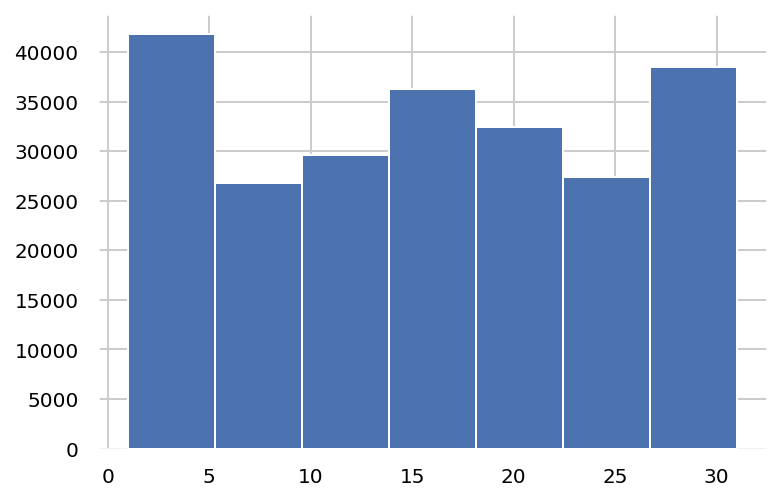

In [13]:
# DAY_OF_MONTH
X['DAY_OF_MONTH'].hist(bins=7)
plt.show()

In [14]:
def month_weeks_range(x):
    if x <= 7:
        return 'week 1'
    elif x <= 14:
        return 'week 2'
    elif x <= 21:
        return 'week 3'
    elif x <= 28:
        return 'week 4'
    else:
        return 'extra week'

X['DAY_OF_MONTH'] = X['DAY_OF_MONTH'].apply(lambda x: month_weeks_range(x))
X['DAY_OF_MONTH'].value_counts()

week 3        54309
week 1        53760
week 4        51917
week 2        49998
extra week    22600
Name: DAY_OF_MONTH, dtype: int64

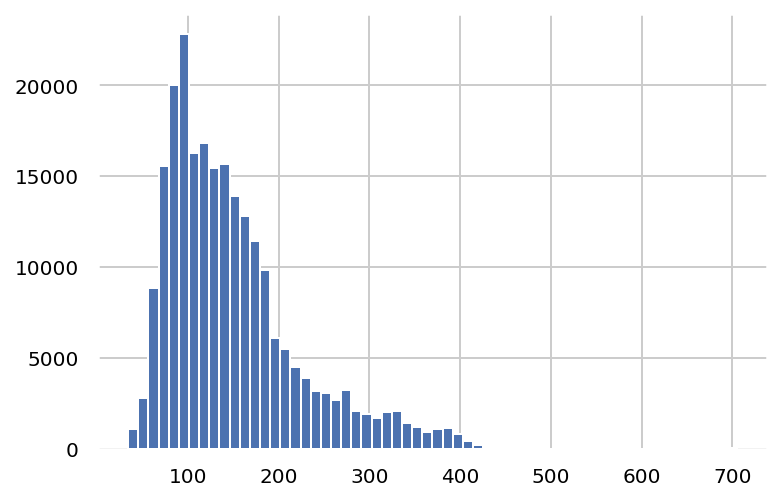

In [15]:
# CRS_ELAPSED_TIME
X['CRS_ELAPSED_TIME'].hist(bins=60)
plt.show()

In [16]:
def crs_time_range(x):
    if x <= 180:
        return '3 hours or less'
    elif x <= 360:
        return '6 hours or less'
    elif x <= 540:
        return '9 hours or less'
    else:
        return '12 hours or less'

X['CRS_ELAPSED_TIME'] = X['CRS_ELAPSED_TIME'].apply(lambda x: crs_time_range(x))
X['CRS_ELAPSED_TIME'].value_counts()

3 hours or less     175244
6 hours or less      52674
9 hours or less       4504
12 hours or less       162
Name: CRS_ELAPSED_TIME, dtype: int64

In [17]:
# DEP_TIME_BLK
X['DEP_TIME_BLK'].value_counts()

1700-1759    16187
1800-1859    14777
1900-1959    14769
1500-1559    14548
1600-1659    14487
1400-1459    14234
1200-1259    14222
1100-1159    13828
2000-2059    13727
1000-1059    13467
0800-0859    13450
1300-1359    13166
0900-0959    12855
0700-0759    12461
0600-0659    12178
2100-2159     9324
2200-2259     7952
0001-0559     4900
2300-2359     2052
Name: DEP_TIME_BLK, dtype: int64

In [18]:
dep_blk = {'0600-0659':'morning', '0700-0759':'morning', '0800-0859':'morning',
           '0900-0959':'morning','1000-1059':'morning', '1100-1159':'morning',
           '1200-1259':'afternoon', '1300-1359':'afternoon', '1400-1459':'afternoon',
           '1500-1559':'afternoon', '1600-1659':'afternoon', '1700-1759':'afternoon',
           '1800-1859':'evening', '1900-1959':'evening','2000-2059':'evening', 
           '2100-2159':'evening', '2200-2259':'evening', 
           '2200-2259':'night', '2300-2359':'night', '0001-0559':'night'}

X['DEP_TIME_BLK'] = X['DEP_TIME_BLK'].replace(dep_blk)
X['DEP_TIME_BLK'].value_counts()

afternoon    86844
morning      78239
evening      52597
night        14904
Name: DEP_TIME_BLK, dtype: int64

--------
## 3. Feature Transformation 

- One-hot encoding categorical variables with over 10 distinct values 
- Ordinal encoding for variables such as date-time 
- Min-max scale numeric variables


In [19]:
X.head()

,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,ORIGIN,DEST,DEP_TIME_BLK,CRS_ELAPSED_TIME,DISTANCE_GROUP,CARRIER_NAME,PILOTS_COPILOTS,PASSENGER_HANDLING,PASS_GEN_SVC_ADMIN,MAINTENANCE,PRCP,SNOW,SNWD,TMAX,AWND
0,week 1,5,WN,HOU,DAL,morning,3 hours or less,1,Southwest Airlines Co.,8989,9668,15475,2482,0.00,0.0,0.0,75.0,9.62
1,week 4,4,OH,CLT,AVL,morning,3 hours or less,1,Comair Inc.,1729,0,1345,471,0.00,0.0,0.0,63.0,1.12
2,week 3,6,OH,ORF,PHL,afternoon,3 hours or less,1,Comair Inc.,1729,0,1345,471,0.00,0.0,0.0,46.0,5.14
3,week 2,7,NK,RDU,MCO,morning,3 hours or less,3,Spirit Air Lines,2126,264,3592,395,0.11,0.0,0.0,52.0,3.58
4,week 2,7,DL,SEA,MSP,morning,6 hours or less,6,Delta Air Lines Inc.,9293,15331,15809,6122,0.03,0.0,0.0,52.0,3.80


### a. Categorical Variables

- OP_UNIQUE_CARRIER (one-hot encode and drop last column)
- ORIGIN (one-hot encode and drop last column)
- DEST (one-hot encode and drop last column)
- CARRIER_NAME (one-hot encode and drop last column)

In [20]:
# Categorical columns
categ_cols = ['OP_UNIQUE_CARRIER','ORIGIN', 'DEST', 'CARRIER_NAME']
X[categ_cols].head()

,OP_UNIQUE_CARRIER,ORIGIN,DEST,CARRIER_NAME
0,WN,HOU,DAL,Southwest Airlines Co.
1,OH,CLT,AVL,Comair Inc.
2,OH,ORF,PHL,Comair Inc.
3,NK,RDU,MCO,Spirit Air Lines
4,DL,SEA,MSP,Delta Air Lines Inc.


**High dimensionality problem** if we one hot encode these columns 

In [21]:
#X = pd.get_dummies(X[categ_cols])
#X.head()

### b. Ordinal Variables

- DAY_OF_MONTH (convert to ordinal numbers)
- DAY_OF_WEEK (already ordinal)
- DISTANCE_GROUP (already ordinal)
- DEP_TIME_BLK (convert to ordinal numbers)
- CRS_ELAPSED_TIME (covert to ordinal numbers)


In [22]:
# Ordinal categorical columns
ord_cols = ['DAY_OF_MONTH', 'DAY_OF_WEEK', 'DISTANCE_GROUP', 'DEP_TIME_BLK', 'CRS_ELAPSED_TIME']
X[ord_cols].head()

,DAY_OF_MONTH,DAY_OF_WEEK,DISTANCE_GROUP,DEP_TIME_BLK,CRS_ELAPSED_TIME
0,week 1,5,1,morning,3 hours or less
1,week 4,4,1,morning,3 hours or less
2,week 3,6,1,afternoon,3 hours or less
3,week 2,7,3,morning,3 hours or less
4,week 2,7,6,morning,6 hours or less


In [23]:
# DAY_OF_MONTH
week_month_ord = {'week 1': 1, 'week 2': 2,
             'week 3': 3,'week 4': 4,
             'extra week': 5}

X['DAY_OF_MONTH'] = X['DAY_OF_MONTH'].replace(week_month_ord)
X['DAY_OF_MONTH'].value_counts()

3    54309
1    53760
4    51917
2    49998
5    22600
Name: DAY_OF_MONTH, dtype: int64

In [24]:
# DISTANCE_GROUP
X['DAY_OF_WEEK'].sort_values().unique()

array([1, 2, 3, 4, 5, 6, 7])

In [25]:
# DISTANCE_GROUP
X['DISTANCE_GROUP'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [26]:
# DEP_TIME_BLK
dep_blk_ord = {'morning': 1,
             'afternoon': 2,
             'evening':3,
             'night':4}

X['DEP_TIME_BLK'] = X['DEP_TIME_BLK'].replace(dep_blk_ord)
X['DEP_TIME_BLK'].value_counts()

2    86844
1    78239
3    52597
4    14904
Name: DEP_TIME_BLK, dtype: int64

In [27]:
# CRS_ELAPSED_TIME
crs_time_ord = {'3 hours or less': 1,
             '6 hours or less': 2,
             '9 hours or less':3,
             '12 hours or less': 4}

X['CRS_ELAPSED_TIME'] = X['CRS_ELAPSED_TIME'].replace(crs_time_ord)
X['CRS_ELAPSED_TIME'].value_counts()

1    175244
2     52674
3      4504
4       162
Name: CRS_ELAPSED_TIME, dtype: int64

### c. Numeric Variables
Use min-max scaler to transform the data in these numeric columns

- PILOTS_COPILOTS
- PASSENGER_HANDLING
- PASS_GEN_SVC_ADMIN
- MAINTENANCE
- PRCP
- SNOW
- SNWD
- TMAX
- AWND

In [28]:
from sklearn.preprocessing import MinMaxScaler

num_cols = ['PILOTS_COPILOTS', 'PASSENGER_HANDLING', 'PASS_GEN_SVC_ADMIN', 'MAINTENANCE', 'PRCP', 'SNOW', 'SNWD', 'TMAX', 'AWND']
X[num_cols].head()


,PILOTS_COPILOTS,PASSENGER_HANDLING,PASS_GEN_SVC_ADMIN,MAINTENANCE,PRCP,SNOW,SNWD,TMAX,AWND
0,8989,9668,15475,2482,0.00,0.0,0.0,75.0,9.62
1,1729,0,1345,471,0.00,0.0,0.0,63.0,1.12
2,1729,0,1345,471,0.00,0.0,0.0,46.0,5.14
3,2126,264,3592,395,0.11,0.0,0.0,52.0,3.58
4,9293,15331,15809,6122,0.03,0.0,0.0,52.0,3.80


In [29]:
scaler = MinMaxScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])
X[num.head()

,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,ORIGIN,DEST,DEP_TIME_BLK,CRS_ELAPSED_TIME,DISTANCE_GROUP,CARRIER_NAME,PILOTS_COPILOTS,PASSENGER_HANDLING,PASS_GEN_SVC_ADMIN,MAINTENANCE,PRCP,SNOW,SNWD,TMAX,AWND
0,1,5,WN,HOU,DAL,1,1,1,Southwest Airlines Co.,0.965086,0.572477,0.978665,0.253863,0.000000,0.0,0.0,0.848101,0.374028
1,4,4,OH,CLT,AVL,1,1,1,Comair Inc.,0.131274,0.000000,0.076078,0.045318,0.000000,0.0,0.0,0.696203,0.043546
2,3,6,OH,ORF,PHL,2,1,1,Comair Inc.,0.131274,0.000000,0.076078,0.045318,0.000000,0.0,0.0,0.481013,0.199844
3,2,7,NK,RDU,MCO,1,1,3,Spirit Air Lines,0.176869,0.015632,0.219610,0.037436,0.015428,0.0,0.0,0.556962,0.139191
4,2,7,DL,SEA,MSP,1,2,6,Delta Air Lines Inc.,1.000000,0.907804,1.000000,0.631339,0.004208,0.0,0.0,0.556962,0.147745


-----

# Final Data for Training 

In [ ]:
X.head()

# Save Transformed Data into Local Private Bucket 

In [30]:
X.shape

(232584, 18)

In [31]:
# independent variable
file_path = Path('../src/data/transformed_data/pretraining_data_X.csv')

if file_path.is_file():
    None
else:
    X.to_csv('../src/data/transformed_data/pretraining_data_X.csv', index=False)

s3_private_path_csv = "s3://{}/ads508/data/merged/pretraining_X".format(bucket)


!aws s3 cp $file_path $s3_private_path_csv/
!aws s3 ls $s3_private_path_csv/

upload: ../src/data/transformed_data/pretraining_data_X.csv to s3://sagemaker-us-east-1-229768475194/ads508/data/merged/pretraining_X/pretraining_data_X.csv
2022-03-27 03:18:58   39130451 pretraining_data_X.csv


In [32]:
y.shape

(232584,)

In [33]:
# Target variable
file_path = Path('../src/data/transformed_data/pretraining_data_y.csv')

if file_path.is_file():
    None
else:
    y.to_csv('../src/data/transformed_data/pretraining_data_y.csv', index=False)

s3_private_path_csv = "s3://{}/ads508/data/merged/pretraining_y".format(bucket)


!aws s3 cp $file_path $s3_private_path_csv/
!aws s3 ls $s3_private_path_csv/

upload: ../src/data/transformed_data/pretraining_data_y.csv to s3://sagemaker-us-east-1-229768475194/ads508/data/merged/pretraining_y/pretraining_data_y.csv
2022-03-27 03:19:00     930346 pretraining_data_y.csv


# Store Variables for the Next Notebooks

In [34]:
%store

Stored variables and their in-db values:
auto_ml_job_name                                      -> 'automl-dm-10-22-14-04'
autopilot_endpoint_arn                                -> 'arn:aws:sagemaker:us-east-1:229768475194:endpoint
autopilot_endpoint_name                               -> 'automl-dm-ep-10-22-58-33'
autopilot_model_arn                                   -> 'arn:aws:sagemaker:us-east-1:229768475194:model/au
autopilot_model_name                                  -> 'automl-dm-model-10-22-58-32'
autopilot_train_s3_uri                                -> 's3://sagemaker-us-east-1-229768475194/data/amazon
balanced_bias_data_jsonlines_s3_uri                   -> 's3://sagemaker-us-east-1-229768475194/bias-detect
balanced_bias_data_s3_uri                             -> 's3://sagemaker-us-east-1-229768475194/bias-detect
bias_data_s3_uri                                      -> 's3://sagemaker-us-east-1-229768475194/bias-detect
comprehend_train_s3_uri                               -> 's

# Release Resources

In [35]:
%%html

<p><b>Shutting down your kernel for this notebook to release resources.</b></p>
<button class="sm-command-button" data-commandlinker-command="kernelmenu:shutdown" style="display:none;">Shutdown Kernel</button>
        
<script>
try {
    els = document.getElementsByClassName("sm-command-button");
    els[0].click();
}
catch(err) {
    // NoOp
}    
</script>

In [36]:
%%javascript

try {
    Jupyter.notebook.save_checkpoint();
    Jupyter.notebook.session.delete();
}
catch(err) {
    // NoOp
}

<IPython.core.display.Javascript object>